In [61]:
# benin_eda.ipynb
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

# 2. Load the data
df = pd.read_csv('../data/togo-dapaong_qc.csv')  

In [62]:
# Initial Data Exploration
print("Data shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nFirst 5 rows:\n", df.head())

# 4. Summary Statistics
print("\nSummary statistics:\n", df.describe(include='all'))

# 5. Missing Value Analysis
missing_values = df.isna().sum()
missing_percent = (missing_values / len(df)) * 100
missing_report = pd.DataFrame({'Missing Values': missing_values, 
                              'Percentage (%)': missing_percent})
print("\nMissing values report:\n", missing_report[missing_report['Missing Values'] > 0])

# Identify columns with >5% nulls
high_missing_cols = missing_percent[missing_percent > 5].index.tolist()
print("\nColumns with >5% missing values:", high_missing_cols)



Data shape: (525600, 19)

Data types:
 Timestamp         object
GHI              float64
DNI              float64
DHI              float64
ModA             float64
ModB             float64
Tamb             float64
RH               float64
WS               float64
WSgust           float64
WSstdev          float64
WD               float64
WDstdev          float64
BP                 int64
Cleaning           int64
Precipitation    float64
TModA            float64
TModB            float64
Comments         float64
dtype: object

First 5 rows:
           Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0  2021-10-25 00:01 -1.3  0.0  0.0   0.0   0.0  24.8  94.5  0.9     1.1   
1  2021-10-25 00:02 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.1     1.6   
2  2021-10-25 00:03 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.2     1.4   
3  2021-10-25 00:04 -1.2  0.0  0.0   0.0   0.0  24.8  94.3  1.2     1.6   
4  2021-10-25 00:05 -1.2  0.0  0.0   0.0   0.0  24.8  94.0  1.3     1.6   

   WS

In [63]:

# Define numeric columns to clean
outlier_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Strict IQR-based outlier capping
for col in outlier_cols:
    if col in df.columns:
        # Calculate IQR bounds
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Cap outliers
        df[col] = np.clip(df[col], lower_bound, upper_bound)

# Verify cleaning
for col in outlier_cols:
    if col in df.columns:
        print(f"{col} range after cleaning: [{df[col].min():.2f}, {df[col].max():.2f}]")

# Save (optional)
# df.to_csv('../data/sierraleone_clean.csv', index=False)



GHI range after cleaning: [-12.70, 1109.30]
DNI range after cleaning: [0.00, 616.00]
DHI range after cleaning: [0.00, 539.25]
ModA range after cleaning: [0.00, 1056.31]
ModB range after cleaning: [0.00, 1027.50]
WS range after cleaning: [0.00, 5.90]
WSgust range after cleaning: [0.00, 8.15]


In [65]:

# Columns to check for outliers (adjust as needed)
outlier_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# 1. Calculate Z-scores and flag outliers
print("Outlier Report (Z-score > 3):")
print("----------------------------")
for col in outlier_cols:
    if col in df.columns:
        # Calculate Z-scores (ignore NaN values)
        z = np.abs(stats.zscore(df[col].dropna()))
        outliers = np.where(z > 3)[0]
        
        # Print outlier info
        print(f"{col}:")
        print(f"  - {len(outliers)} outliers detected")
        if len(outliers) > 0:
            outlier_values = df[col].iloc[outliers]
            print(f"  - Max outlier value: {outlier_values.max():.2f}")
            print(f"  - Min outlier value: {outlier_values.min():.2f}")

# 2. Cap outliers at Z-score = 3 threshold
for col in outlier_cols:
    if col in df.columns:
        # Calculate mean and std (ignore NaN)
        col_mean = df[col].mean()
        col_std = df[col].std()
        
        # Calculate upper/lower bounds (3 std deviations)
        upper_bound = col_mean + 3 * col_std
        lower_bound = col_mean - 3 * col_std
        
        # Cap values
        df[col] = np.where(df[col] > upper_bound, upper_bound,
                          np.where(df[col] < lower_bound, lower_bound, df[col]))

# 3. Verify results
print("\nPost-Cleaning Ranges:")
print("---------------------")
for col in outlier_cols:
    if col in df.columns:
        print(f"{col}: [{df[col].min():.2f}, {df[col].max():.2f}]")

# 4. Save cleaned data (optional)
df.to_csv('../data/togo_clean.csv', index=False)
print("\nCleaned data saved to '../data/togo_clean.csv'")

Outlier Report (Z-score > 3):
----------------------------
GHI:
  - 0 outliers detected
DNI:
  - 0 outliers detected
DHI:
  - 0 outliers detected
ModA:
  - 0 outliers detected
ModB:
  - 0 outliers detected
WS:
  - 0 outliers detected
WSgust:
  - 0 outliers detected

Post-Cleaning Ranges:
---------------------
GHI: [-12.70, 1109.30]
DNI: [0.00, 616.00]
DHI: [0.00, 539.25]
ModA: [0.00, 1056.31]
ModB: [0.00, 1027.50]
WS: [0.00, 5.90]
WSgust: [0.00, 8.15]

Cleaned data saved to '../data/togo_clean.csv'


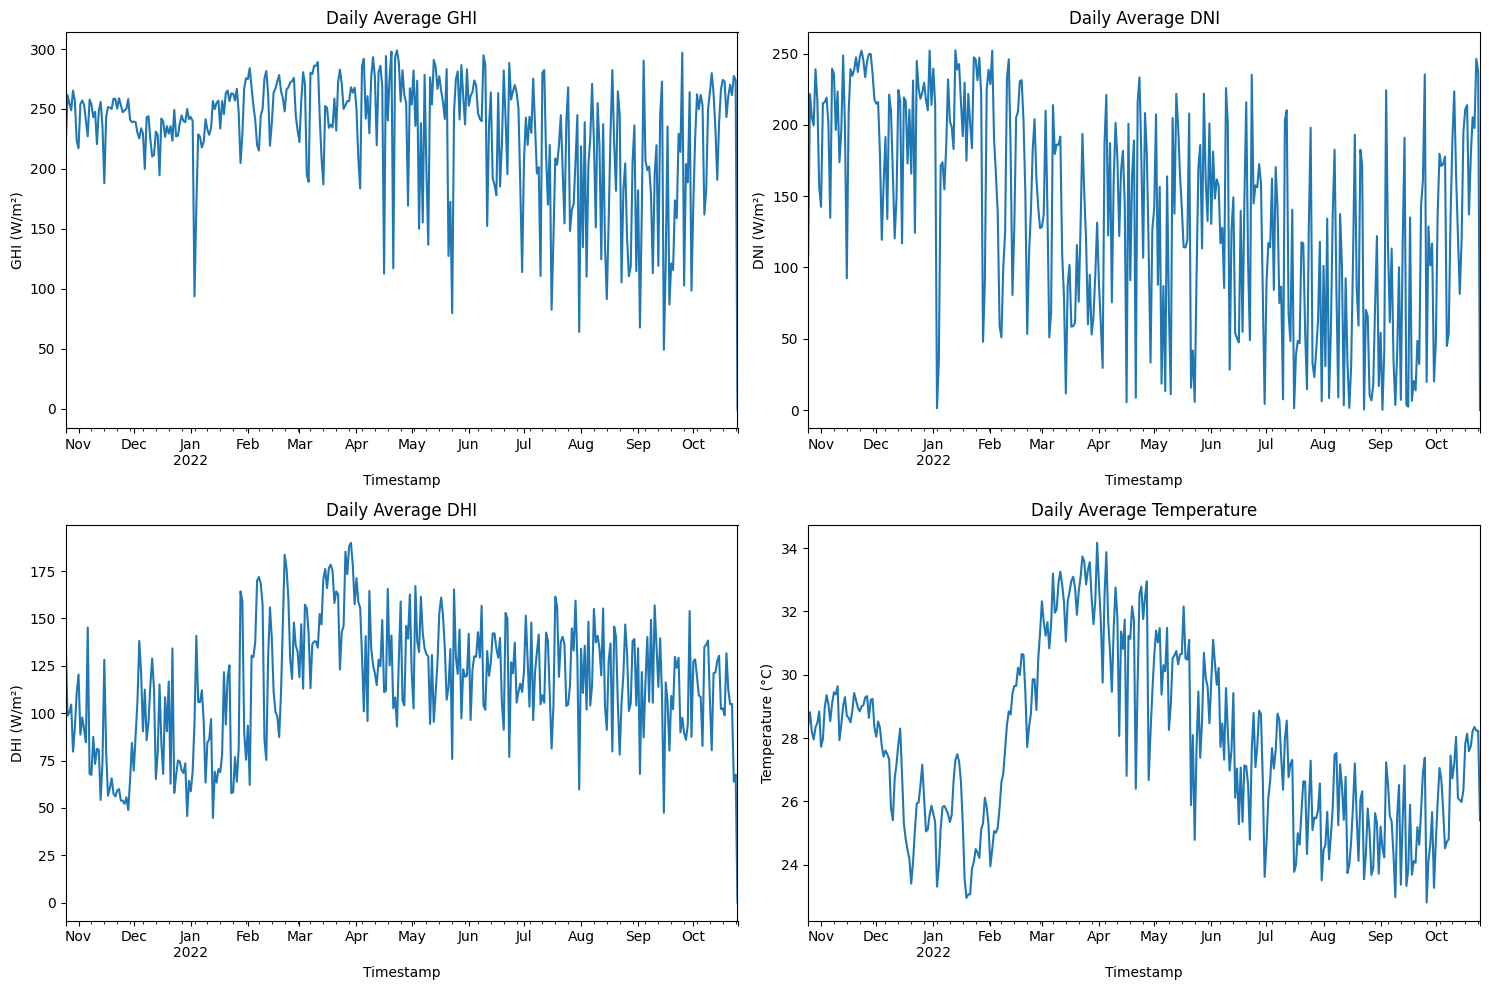

In [66]:
# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

#  Time series plots
plt.figure(figsize=(15, 10))

# GHI over time
plt.subplot(2, 2, 1)
df.set_index('Timestamp')['GHI'].resample('D').mean().plot(title='Daily Average GHI')
plt.ylabel('GHI (W/m²)')

# DNI over time
plt.subplot(2, 2, 2)
df.set_index('Timestamp')['DNI'].resample('D').mean().plot(title='Daily Average DNI')
plt.ylabel('DNI (W/m²)')

# DHI over time
plt.subplot(2, 2, 3)
df.set_index('Timestamp')['DHI'].resample('D').mean().plot(title='Daily Average DHI')
plt.ylabel('DHI (W/m²)')

# Ambient temperature over time
plt.subplot(2, 2, 4)
df.set_index('Timestamp')['Tamb'].resample('D').mean().plot(title='Daily Average Temperature')
plt.ylabel('Temperature (°C)')

plt.tight_layout()
plt.show()


Average module performance before and after cleaning:
                 ModA        ModB
Cleaning                        
0         225.844380  219.231042
1         534.989413  531.934164


<Figure size 1000x500 with 0 Axes>

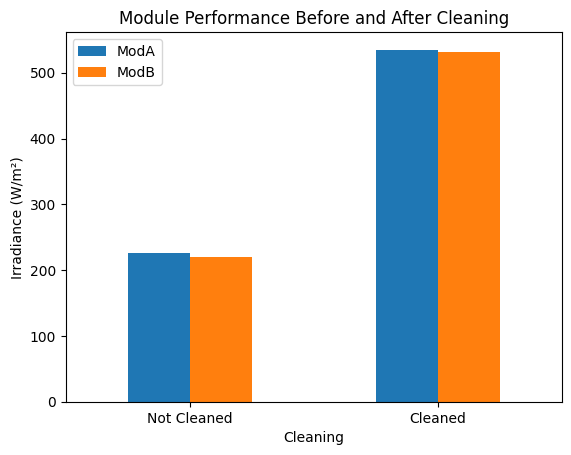

In [67]:
# 11. Cleaning impact on module performance
cleaning_impact = df.groupby('Cleaning')[['ModA', 'ModB']].mean()
print("\nAverage module performance before and after cleaning:\n", cleaning_impact)

plt.figure(figsize=(10, 5))
cleaning_impact.plot(kind='bar')
plt.title('Module Performance Before and After Cleaning')
plt.ylabel('Irradiance (W/m²)')
plt.xticks([0, 1], ['Not Cleaned', 'Cleaned'], rotation=0)
plt.show()


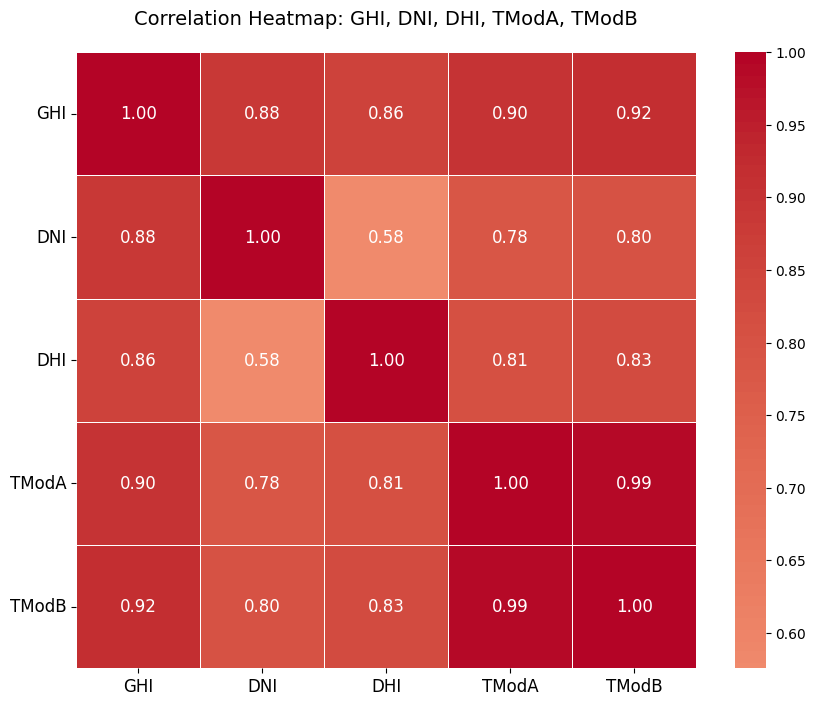


Key Correlation Insights:
1. GHI and DNI correlation: 0.88
2. GHI and DHI correlation: 0.86
3. Module temperatures correlation: 0.99
4. DNI and TModA correlation: 0.78


In [68]:
# Correlation Analysis 

# Create a subset with only the specified variables
corr_subset = df[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']]

# Generate correlation matrix
corr_matrix = corr_subset.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            annot_kws={'size': 12}, fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: GHI, DNI, DHI, TModA, TModB', pad=20, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.show()

# Interpretation of key correlations
print("\nKey Correlation Insights:")
print(f"1. GHI and DNI correlation: {corr_matrix.loc['GHI', 'DNI']:.2f}")
print(f"2. GHI and DHI correlation: {corr_matrix.loc['GHI', 'DHI']:.2f}")
print(f"3. Module temperatures correlation: {corr_matrix.loc['TModA', 'TModB']:.2f}")
print(f"4. DNI and TModA correlation: {corr_matrix.loc['DNI', 'TModA']:.2f}")

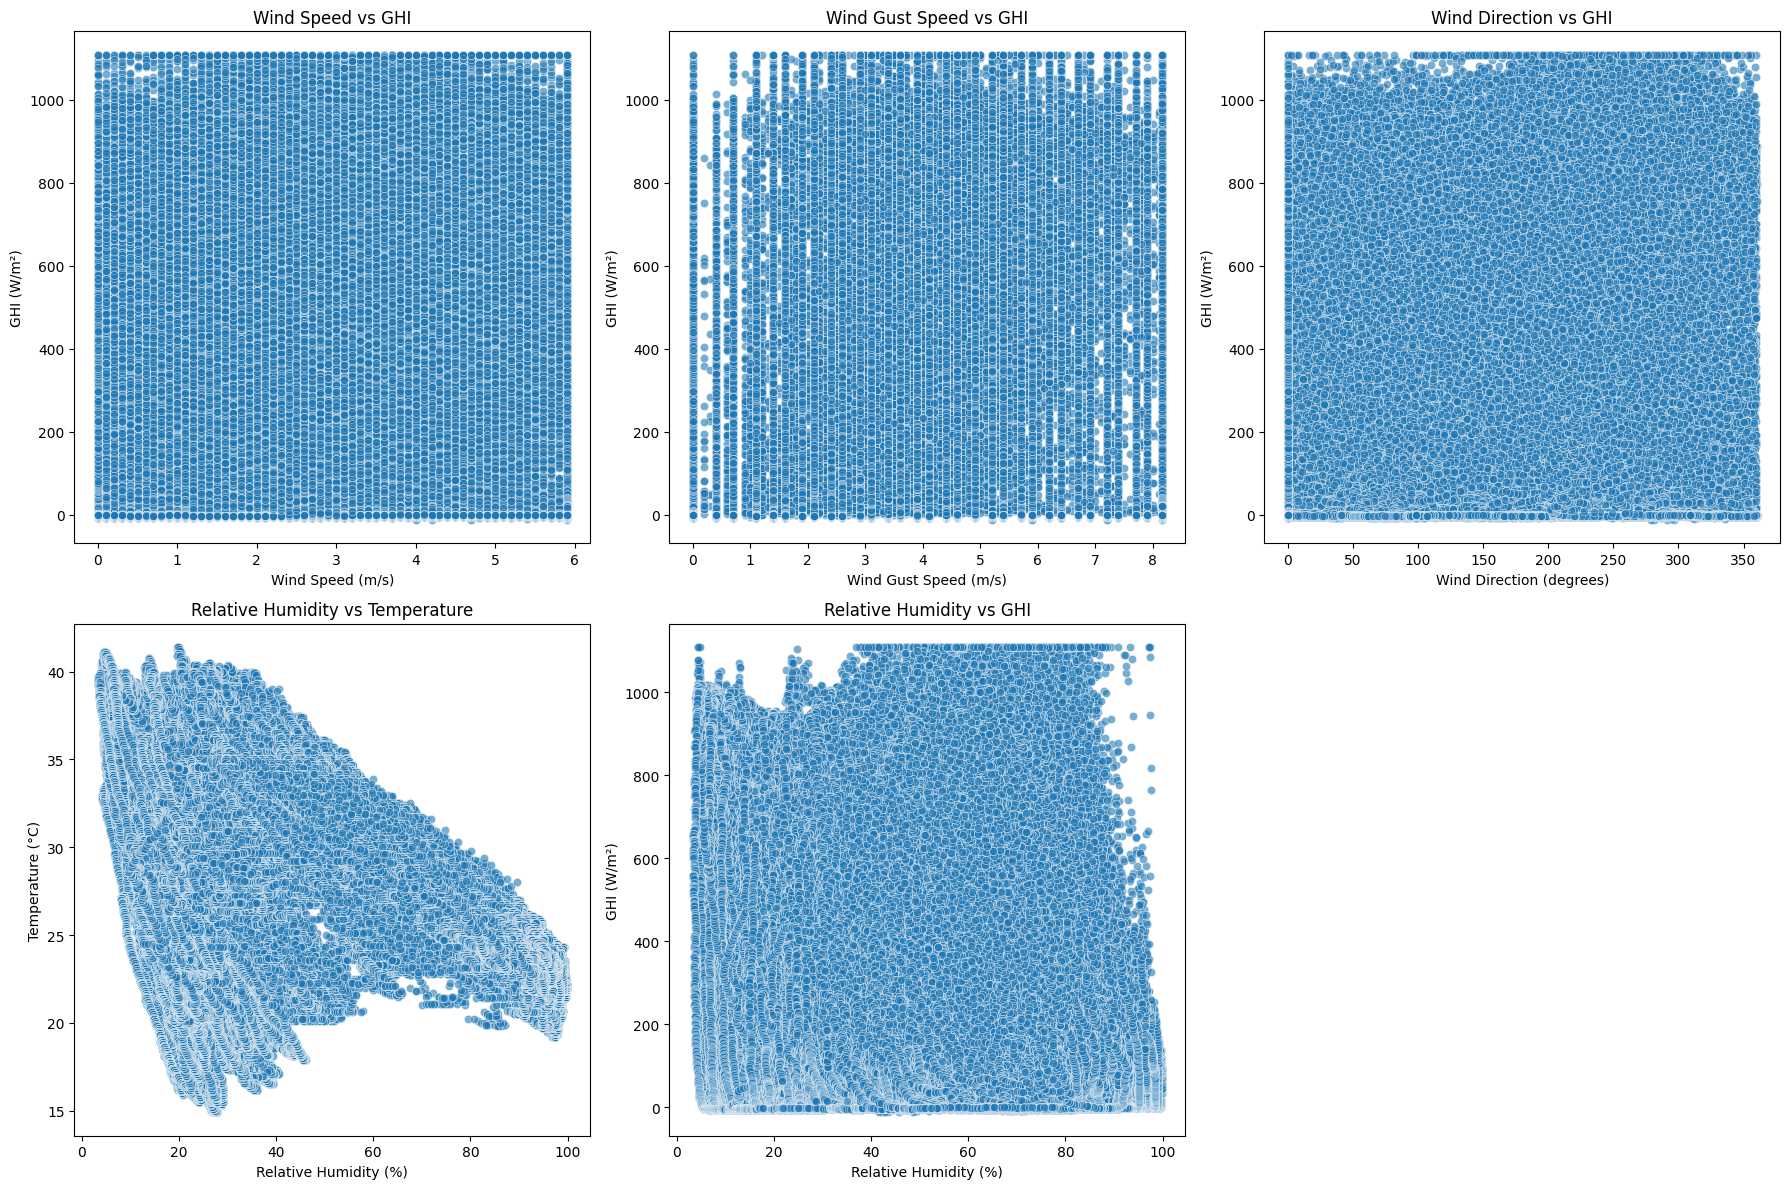

In [69]:
#  Specified Scatter Plots
plt.figure(figsize=(18, 12))

# WS vs GHI
plt.subplot(2, 3, 1)
sns.scatterplot(data=df, x='WS', y='GHI', alpha=0.6)
plt.title('Wind Speed vs GHI', fontsize=12)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('GHI (W/m²)')

# WSgust vs GHI
plt.subplot(2, 3, 2)
sns.scatterplot(data=df, x='WSgust', y='GHI', alpha=0.6)
plt.title('Wind Gust Speed vs GHI', fontsize=12)
plt.xlabel('Wind Gust Speed (m/s)')
plt.ylabel('GHI (W/m²)')

# WD vs GHI
plt.subplot(2, 3, 3)
sns.scatterplot(data=df, x='WD', y='GHI', alpha=0.6)
plt.title('Wind Direction vs GHI', fontsize=12)
plt.xlabel('Wind Direction (degrees)')
plt.ylabel('GHI (W/m²)')

# RH vs Tamb
plt.subplot(2, 3, 4)
sns.scatterplot(data=df, x='RH', y='Tamb', alpha=0.6)
plt.title('Relative Humidity vs Temperature', fontsize=12)
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Temperature (°C)')

# RH vs GHI
plt.subplot(2, 3, 5)
sns.scatterplot(data=df, x='RH', y='GHI', alpha=0.6)
plt.title('Relative Humidity vs GHI', fontsize=12)
plt.xlabel('Relative Humidity (%)')
plt.ylabel('GHI (W/m²)')

plt.tight_layout()
plt.show()

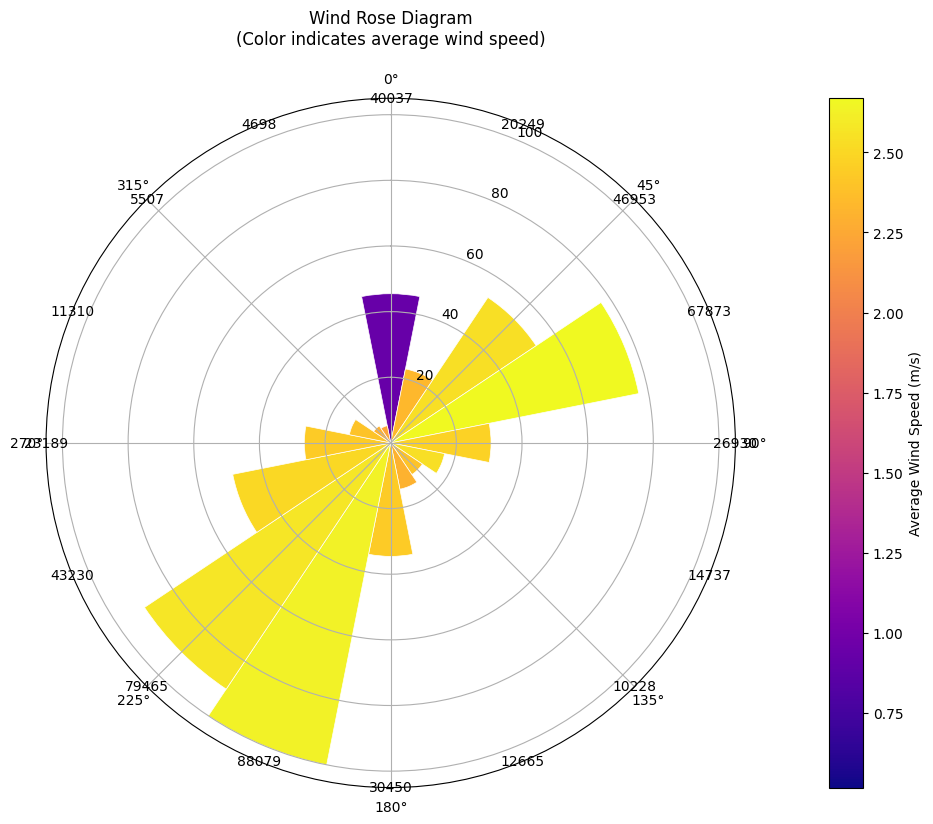

In [70]:
# Wind Rose Analysis
from matplotlib.cm import ScalarMappable
# 1. Prepare wind data
df['WD'] = pd.to_numeric(df['WD'], errors='coerce')
df_wind = df.dropna(subset=['WD', 'WS']).copy()

# 2. Create properly aligned bins and labels
n_bins = 16  # 16 cardinal directions
bin_edges = np.linspace(0, 360, n_bins + 1)  # 17 edges for 16 bins
directions = ['N', 'NNE', 'NE', 'ENE', 
              'E', 'ESE', 'SE', 'SSE',
              'S', 'SSW', 'SW', 'WSW',
              'W', 'WNW', 'NW', 'NNW']

# 3. Categorize wind directions
df_wind['WD_bin'] = pd.cut(
    df_wind['WD'],
    bins=bin_edges,
    labels=directions,
    include_lowest=True
)

# 4. Create polar plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, polar=True)

# Calculate stats
wind_stats = df_wind.groupby('WD_bin').agg({
    'WS': 'mean',
    'WD': 'count'
}).rename(columns={'WD': 'Frequency'}).reindex(directions)

# Normalize frequency for visualization
max_freq = wind_stats['Frequency'].max()
wind_stats['Normalized'] = wind_stats['Frequency'] / max_freq * 100

# Create bars
theta = np.linspace(0, 2*np.pi, len(wind_stats), endpoint=False)
width = 2 * np.pi / len(wind_stats)
bars = ax.bar(
    theta, 
    wind_stats['Normalized'],
    width=width,
    color=plt.cm.plasma(wind_stats['WS'] / wind_stats['WS'].max()),
    edgecolor='white',
    linewidth=0.5
)

# Configure polar plot
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)  # Clockwise
ax.set_title('Wind Rose Diagram\n(Color indicates average wind speed)', pad=20)

# Create colorbar
sm = ScalarMappable(
    cmap='plasma',
    norm=plt.Normalize(
        vmin=wind_stats['WS'].min(), 
        vmax=wind_stats['WS'].max()
    )
)
sm.set_array([])  # Required for colorbar creation
cbar = plt.colorbar(
    sm,
    ax=ax,
    pad=0.1,
    label='Average Wind Speed (m/s)'
)

# Add frequency labels
for angle, freq in zip(theta, wind_stats['Frequency']):
    if freq > 0:  # Only label directions with data
        ax.text(
            angle, 
            wind_stats.loc[directions, 'Normalized'].max() + 5, 
            f"{freq}",
            ha='center',
            va='center'
        )

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of Wind Speed')

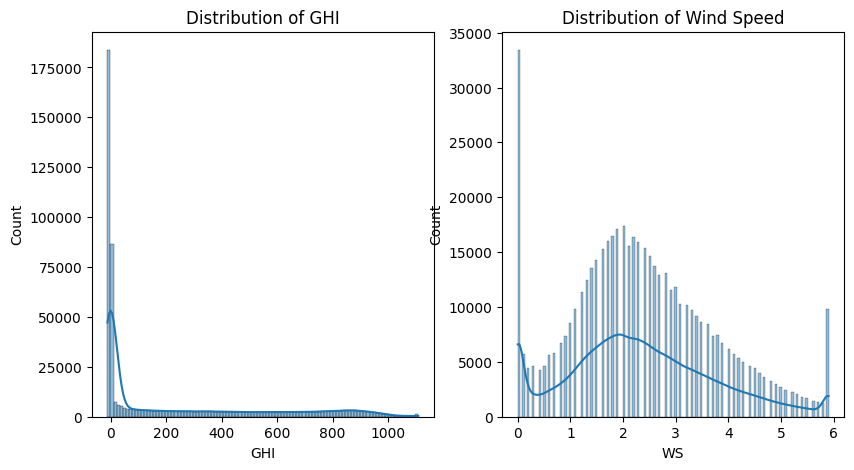

In [71]:
# Temperature and radiation relationships
plt.figure(figsize=(15, 5))

# Histogram of GHI
plt.subplot(1, 3, 1)
sns.histplot(df['GHI'], kde=True)
plt.title('Distribution of GHI')

# Histogram of WS
plt.subplot(1, 3, 2)
sns.histplot(df['WS'], kde=True)
plt.title('Distribution of Wind Speed')



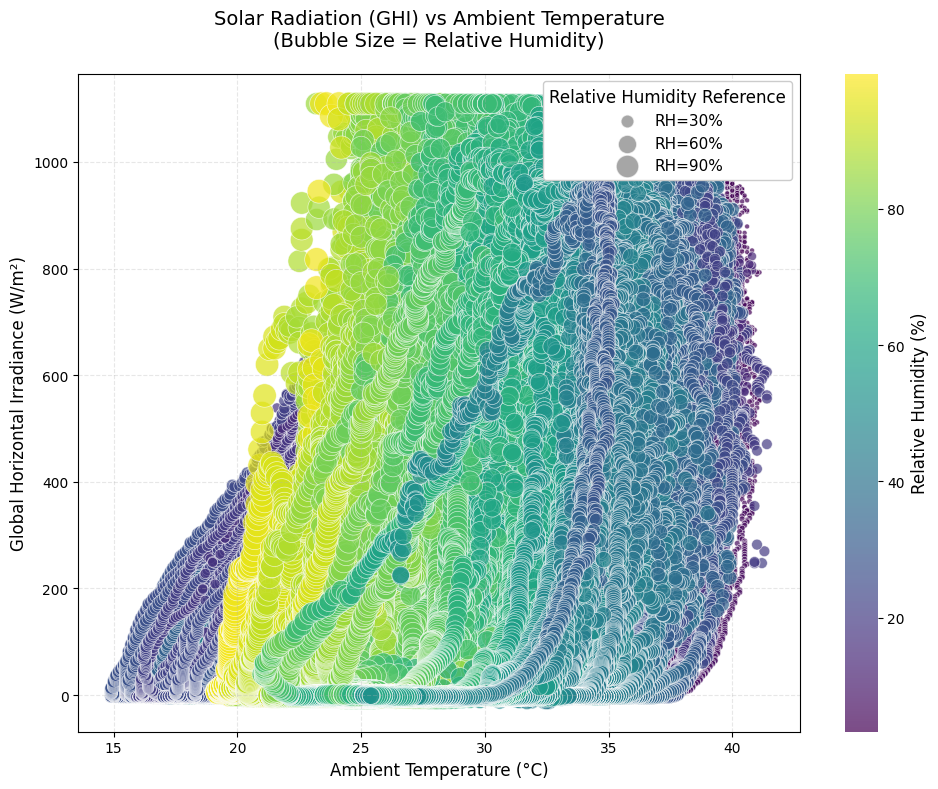

In [72]:
# GHI vs Temperature with RH as bubble size
plt.figure(figsize=(10, 8))

# Create the scatter plot with enhanced styling
scatter = plt.scatter(
    x=df['Tamb'], 
    y=df['GHI'],
    s=df['RH']*3,  # Increased bubble size multiplier for better visibility
    c=df['RH'],    # Color by RH for additional dimension
    alpha=0.7,     # Slightly more opaque
    cmap='viridis',
    edgecolors='white',  # Add white borders to bubbles
    linewidth=0.5
)

# Add titles and labels with improved formatting
plt.title('Solar Radiation (GHI) vs Ambient Temperature\n(Bubble Size = Relative Humidity)', 
          fontsize=14, pad=20)
plt.xlabel('Ambient Temperature (°C)', fontsize=12)
plt.ylabel('Global Horizontal Irradiance (W/m²)', fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.3)

# Create improved legend for bubble sizes
for rh in [30, 60, 90]:
    plt.scatter([], [],  # Empty scatter points for legend
                s=rh*3, 
                alpha=0.7,
                label=f'RH={rh}%', 
                c='gray',
                edgecolors='white')

legend = plt.legend(
    title='Relative Humidity Reference',
    title_fontsize=12,
    fontsize=11,
    framealpha=1,
    loc='upper right'
)

# Add colorbar for RH values
cbar = plt.colorbar(scatter)
cbar.set_label('Relative Humidity (%)', fontsize=12)
cbar.outline.set_visible(False)  # Remove colorbar border

# Adjust layout to prevent clipping
plt.tight_layout()
plt.show()